In [1]:
%run correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/eggNOG/

/work/clusterEvo/new_tests/eggNOG


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr, mannwhitneyu
import igraph as ig
from Bio import SeqIO
import requests

In [3]:
single_copy = pd.read_csv('single_copy_genes.tsv', sep='\t', index_col=0)
single_copy.head()

,group_id,num_proteins,num_taxa,members,taxa
1277,arCOG00079,112,112,"1041930.Mtc_1976,1054217.TALC_01539,1070774.J0...","[1041930, 1054217, 1070774, 1071085, 1094980, ..."
1279,arCOG00081,166,166,"1006006.Mcup_0318,1033806.HTIA_0777,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."
1519,arCOG00354,112,112,"1033806.HTIA_1426,1041930.Mtc_0671,1042877.GQS...","[1033806, 1041930, 1042877, 1070774, 1071085, ..."
1520,arCOG00355,106,106,"1033806.HTIA_0952,1041930.Mtc_0275,1042877.GQS...","[1033806, 1041930, 1042877, 1070774, 1071085, ..."
1561,arCOG00410,168,168,"1006006.Mcup_0164,1033806.HTIA_1385,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."


In [4]:
if not os.path.isfile('odr_regressions.tsv'):
    group_ids = []
    trees     = []
    for filename in os.listdir('trees/'):
        group_ids.append(filename.replace('.nwk', ''))
        trees.append(ete3.Tree(f'trees/{filename}'))

    pool          = multiprocessing.Pool(processes = 10)
    dist_matrices = pool.map(get_matrix_from_tree, trees)

    table = {group:matrix for group, matrix in zip(group_ids, dist_matrices)}

    regressions, r2s, pearson = [], [], []
    group_combinations = []
    for group1, group2 in itertools.combinations(group_ids, 2):

        group_combinations.append((group1, group2))
        tmp_reg, tmp_r2 = assess_coevolution(table[group1], 
                                             table[group2], 
                                             weighted_r2=False)
        regressions.append(tmp_reg)
        r2s.append(tmp_r2)
        pearson.append(assess_coevolution(table[group1], table[group2], pearson=True)[0])

    r2s = np.array(r2s)
    r2s[r2s < 0] = 0

    odr_edges       = pd.DataFrame(columns=['group1', 'group2'],
                                   data   =group_combinations)
    odr_edges['r2'] = r2s

    pearson_edges       = pd.DataFrame(columns=['group1', 'group2'],
                                       data   =group_combinations)
    pearson_edges['r2'] = pearson

    pd.DataFrame(columns=group_ids,
                 index  =group_ids,
                 data   =squareform(r2s)).to_csv('odr_regressions.tsv', sep='\t')
    pd.DataFrame(columns=group_ids,
                 index  =group_ids,
                 data   =squareform(pearson)).to_csv('pearson_correlations.tsv', sep='\t')
else:
    odr_matrix     = pd.read_csv('odr_regressions.tsv',      delim_whitespace=True, index_col=0)
    pearson_matrix = pd.read_csv('pearson_correlations.tsv', delim_whitespace=True, index_col=0)
    
    group_ids = odr_matrix.index

    triu_indices        = np.triu_indices_from(odr_matrix, k=1)
    odr_edges           = pd.DataFrame()
    odr_edges['group1'] = odr_matrix.index[ triu_indices[0]]
    odr_edges['group2'] = odr_matrix.index[ triu_indices[1]]
    odr_edges['r2' ]    = odr_matrix.values[triu_indices]
    
    triu_indices            = np.triu_indices_from(pearson_matrix, k=1)
    pearson_edges           = pd.DataFrame()
    pearson_edges['group1'] = pearson_matrix.index[ triu_indices[0]]
    pearson_edges['group2'] = pearson_matrix.index[ triu_indices[1]]
    pearson_edges['r2' ]    = pearson_matrix.values[triu_indices]

In [5]:
geo_matrix = pd.read_csv('geodesic_distances.csv', index_col=0)
geo_matrix = geo_matrix.reindex(index  =group_ids,
                                columns=group_ids)
rf_matrix  = pd.read_csv('rf_distances.csv',       index_col=0)
rf_matrix  = rf_matrix.reindex(index  =group_ids,
                               columns=group_ids)

triu_indices           = np.triu_indices_from(geo_matrix, k=1)
geo_edges              = pd.DataFrame()
geo_edges['group1']    = geo_matrix.index[ triu_indices[0]]
geo_edges['group2']    = geo_matrix.index[ triu_indices[1]]
geo_edges['geodesic' ] = 1/geo_matrix.values[triu_indices]

triu_indices       = np.triu_indices_from(rf_matrix, k=1)
rf_edges           = pd.DataFrame()
rf_edges['group1'] = rf_matrix.index[ triu_indices[0]]
rf_edges['group2'] = rf_matrix.index[ triu_indices[1]]
rf_edges['rf' ]    = 1/rf_matrix.values[triu_indices]

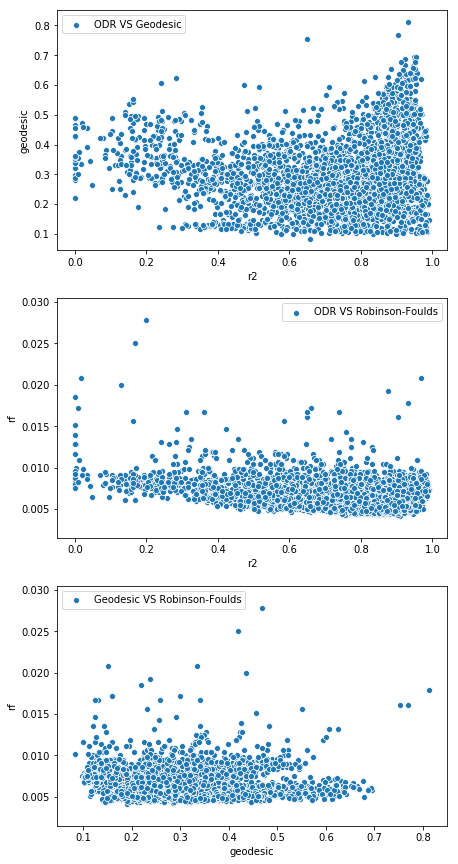

In [6]:
fig, axs = plt.subplots(nrows=3, figsize=(7, 15))

sns.scatterplot(odr_edges.r2,
                geo_edges.geodesic,
                ax   =axs[0],
                label='ODR VS Geodesic')

sns.scatterplot(odr_edges.r2,
                rf_edges.rf,
                ax   =axs[1],
                label='ODR VS Robinson-Foulds')

sns.scatterplot(geo_edges.geodesic,
                rf_edges.rf,
                ax   =axs[2],
                label='Geodesic VS Robinson-Foulds');

In [7]:
odr_graph = ig.Graph.TupleList(edges=odr_edges.loc[:, ['group1', 
                                                       'group2', 
                                                       'r2']].itertuples(index=False), 
                              directed=False, 
                              weights =True)
odr_clusters = odr_graph.community_multilevel(weights='weight')

geo_graph = ig.Graph.TupleList(edges=geo_edges.loc[:, ['group1', 
                                                       'group2', 
                                                       'geodesic']].itertuples(index=False), 
                              directed=False, 
                              weights =True)
geo_clusters = geo_graph.community_multilevel(weights='weight')

rf_graph = ig.Graph.TupleList(edges=rf_edges.loc[:, ['group1', 
                                                     'group2', 
                                                     'rf']].itertuples(index=False), 
                              directed=False, 
                              weights =True)
rf_clusters = rf_graph.community_multilevel(weights='weight')

In [8]:
cluster_df = pd.DataFrame(columns=['odr', 'geo', 'rf'],
                          index  =geo_graph.vs['name'],
                          data   =zip(odr_clusters.membership,
                                      geo_clusters.membership,
                                       rf_clusters.membership))

In [9]:
#
# assemble gene order of reference genomes
#

genome_structures = {}
for filename in os.listdir('reference_genomes/'):
    if not filename.endswith('.gb'):
        continue

    taxid = filename.replace('.gb', '')
    genome_structures[taxid] = []
    
    genbank = SeqIO.parse(f'reference_genomes/{filename}', 'gb')
    for entry in genbank:
        
        locus_tags = []
        for feature in entry.features:
            if feature.type == 'CDS':
                if 'locus_tag' in feature.qualifiers:
                    locus_tags.append(feature.qualifiers['locus_tag'][0])
                else:
                    locus_tags.append('None')

        genome_structures[taxid].append('-'.join(locus_tags))
    
    genome_structures[taxid] = '_-_'.join(genome_structures[taxid])

In [10]:
#
# test adjacency of single copy genes from each reference genome
#

recruited_cds      = {taxid:[] 
                      for taxid in genome_structures.keys()}
locus_tag_to_group = {}
for index, row in single_copy.iterrows():
    
    for taxid in recruited_cds:
        
        if re.search(fr'\b{taxid}\b', row.taxa):
            locus_tag = re.search(f',{taxid}\.([^,]+)', 
                                  row.members).group(1)
            recruited_cds[taxid].append(locus_tag)
            
            locus_tag_to_group[locus_tag] = row.group_id            
            
adjacent_pairs = {}
for taxid, cds_order in genome_structures.items():
    
    adjacent_pairs[taxid] = []
    
    for cds1, cds2 in itertools.combinations(recruited_cds[taxid], 2):
        if re.search(f'({cds1}|{cds2})(-[^-]+){{0,5}}-({cds1}|{cds2})', cds_order):
            adjacent_pairs[taxid].append(frozenset([locus_tag_to_group[cds1], 
                                                    locus_tag_to_group[cds2]]))

distant_pairs = {}
for taxid, cds_order in genome_structures.items():
    
    distant_pairs[taxid] = []
    
    for cds1, cds2 in itertools.combinations(recruited_cds[taxid], 2):
        if re.search(f'({cds1}|{cds2})(-[^-]+){{100,9999}}-({cds1}|{cds2})', cds_order):
            distant_pairs[taxid].append(frozenset([locus_tag_to_group[cds1], 
                                                   locus_tag_to_group[cds2]]))

tmp_distant_pairs = []
for taxid, pairs in distant_pairs.items():
    tmp_distant_pairs.extend(pairs)
distant_frequency = Counter(tmp_distant_pairs)

tmp_adjacent_pairs = []
for taxid, pairs in adjacent_pairs.items():
    tmp_adjacent_pairs.extend(pairs)
adjacency_frequency = Counter(tmp_adjacent_pairs)

In [11]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = odr_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.r2)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = odr_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.r2)

hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol)
effect_size = cles(distant_genes_coevol, adjacent_genes_coevol)

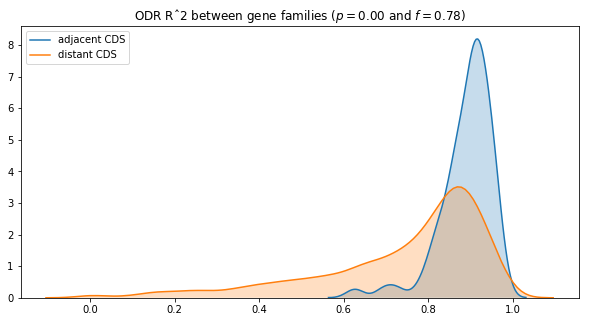

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [13]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = pearson_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.r2)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = pearson_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.r2)

hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol)
effect_size = cles(distant_genes_coevol, adjacent_genes_coevol)

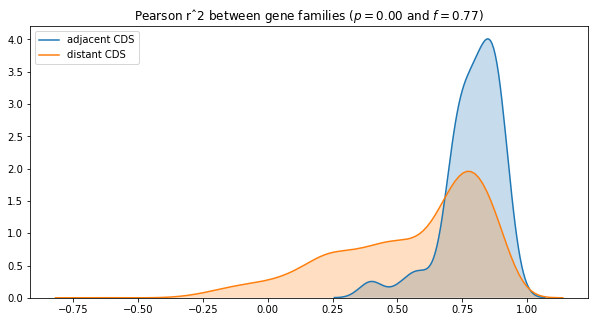

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'Pearson rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [15]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = geo_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.geodesic)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = geo_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.geodesic)
        
hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol)
effect_size = cles(adjacent_genes_coevol, distant_genes_coevol)

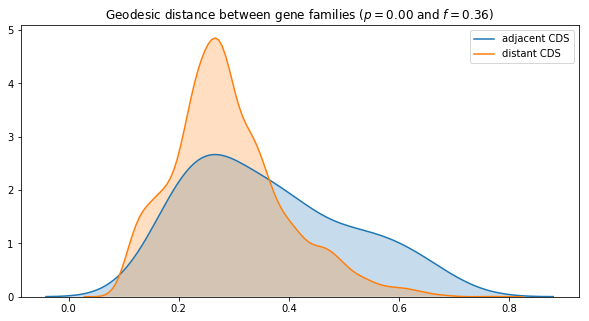

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'Geodesic distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [17]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = rf_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.rf)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = rf_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.rf)
        
hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol)
effect_size = cles(adjacent_genes_coevol, distant_genes_coevol)

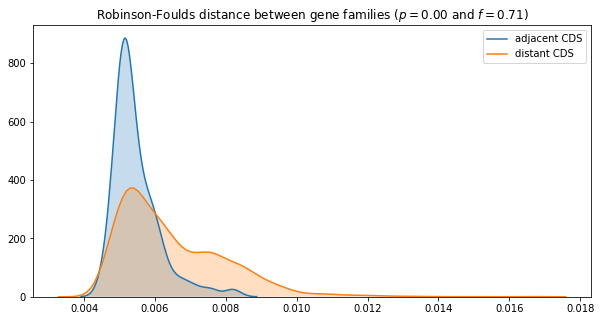

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [19]:
#
# group functionally related genes
#
combined_related_pairs   = []
combined_unrelated_pairs = []

for taxid, taxon_cds in recruited_cds.items():
    ppi = pd.read_csv(f'reference_genomes/{taxid}.protein.links.v11.0.txt', delim_whitespace=True)

    recruited_ppi = ppi.query(f'(protein1 in {taxon_cds}) & ' 
                              f'(protein2 in {taxon_cds})')
    strong_ppi    = recruited_ppi.query('(combined_score >= 700)')

    related_pairs = set()
    for protein1, protein2 in strong_ppi[['protein1', 
                                          'protein2']].itertuples(index=False, 
                                                                  name=None):
        related_pairs.add( frozenset([locus_tag_to_group[protein1], 
                                      locus_tag_to_group[protein2]]) )

    all_ppi_pairs = set([frozenset([locus_tag_to_group[protein1], 
                                    locus_tag_to_group[protein2]]) 
                         for protein1, protein2 in recruited_ppi[['protein1', 
                                                                  'protein2']].itertuples(index=False, 
                                                                                          name=None)])
    all_possible_pairs = set([frozenset([locus_tag_to_group[protein1], 
                                         locus_tag_to_group[protein2]]) 
                         for protein1, protein2 in itertools.combinations(taxon_cds, 2)])

    unrelated_pairs = all_possible_pairs.difference(all_ppi_pairs)
    
    combined_related_pairs.extend(  related_pairs)
    combined_unrelated_pairs.extend(unrelated_pairs)

related_pairs_frequency   = Counter(combined_related_pairs)
unrelated_pairs_frequency = Counter(combined_unrelated_pairs)

In [20]:
related_genes_coevol = []
for pair, count in related_pairs_frequency.items():
    if count >= 5:
        row = odr_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        related_genes_coevol.append(row.r2)

unrelated_genes_coevol = []
for pair, count in unrelated_pairs_frequency.items():
    if count >= 5:
        row = odr_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        unrelated_genes_coevol.append(row.r2)
        
hypothesis = mannwhitneyu(related_genes_coevol,
                          unrelated_genes_coevol)
effect_size = cles(unrelated_genes_coevol, related_genes_coevol)

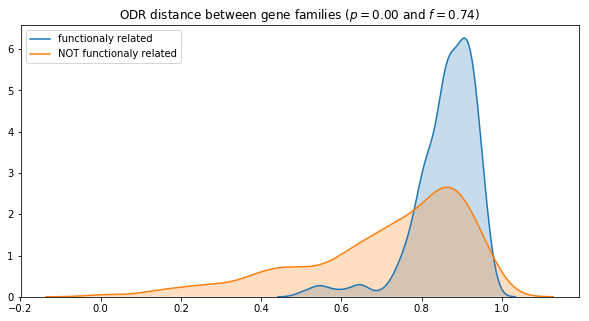

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(related_genes_coevol,   
            shade=True, 
            label='functionaly related', 
            ax=ax)
sns.kdeplot(unrelated_genes_coevol, 
            shade=True, 
            label='NOT functionaly related', 
            ax=ax)

ax.set_title(f'ODR distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [22]:
related_genes_coevol = []
for pair, count in related_pairs_frequency.items():
    if count >= 5:
        row = pearson_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        related_genes_coevol.append(row.r2)

unrelated_genes_coevol = []
for pair, count in unrelated_pairs_frequency.items():
    if count >= 5:
        row = pearson_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        unrelated_genes_coevol.append(row.r2)
        
hypothesis = mannwhitneyu(related_genes_coevol,
                          unrelated_genes_coevol)
effect_size = cles(unrelated_genes_coevol, related_genes_coevol)

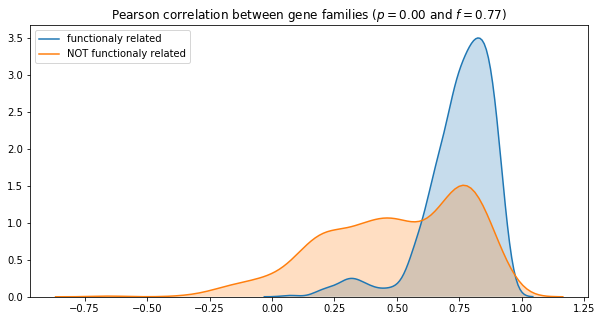

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(related_genes_coevol,   
            shade=True, 
            label='functionaly related', 
            ax=ax)
sns.kdeplot(unrelated_genes_coevol, 
            shade=True, 
            label='NOT functionaly related', 
            ax=ax)

ax.set_title(f'Pearson correlation between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [24]:
related_genes_coevol = []
for pair, count in related_pairs_frequency.items():
    if count >= 5:
        row = geo_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        related_genes_coevol.append(row.geodesic)

unrelated_genes_coevol = []
for pair, count in unrelated_pairs_frequency.items():
    if count >= 5:
        row = geo_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        unrelated_genes_coevol.append(row.geodesic)
        
hypothesis = mannwhitneyu(related_genes_coevol,
                          unrelated_genes_coevol)
effect_size = cles(related_genes_coevol, unrelated_genes_coevol)

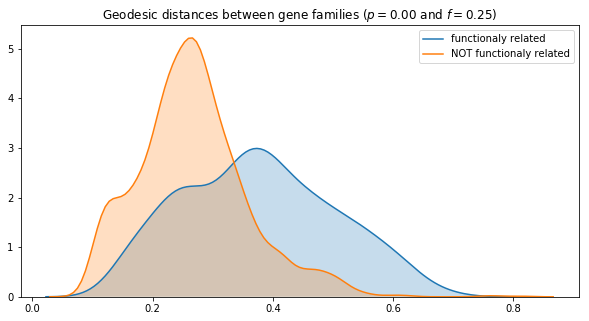

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(related_genes_coevol,   
            shade=True, 
            label='functionaly related', 
            ax=ax)
sns.kdeplot(unrelated_genes_coevol, 
            shade=True, 
            label='NOT functionaly related', 
            ax=ax)

ax.set_title(f'Geodesic distances between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [26]:
related_genes_coevol = []
for pair, count in related_pairs_frequency.items():
    if count >= 5:
        row = rf_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        related_genes_coevol.append(row.rf)

unrelated_genes_coevol = []
for pair, count in unrelated_pairs_frequency.items():
    if count >= 5:
        row = rf_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        unrelated_genes_coevol.append(row.rf)
        
hypothesis = mannwhitneyu(related_genes_coevol,
                          unrelated_genes_coevol)
effect_size = cles(related_genes_coevol, unrelated_genes_coevol)

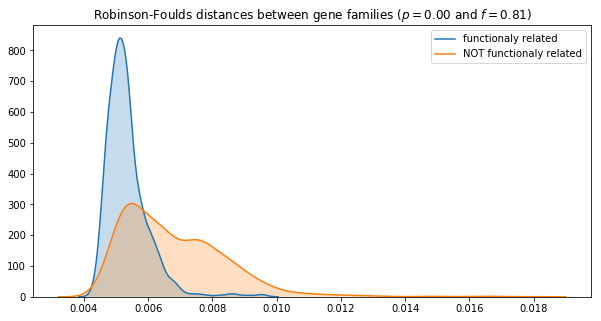

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(related_genes_coevol,   
            shade=True, 
            label='functionaly related', 
            ax=ax)
sns.kdeplot(unrelated_genes_coevol, 
            shade=True, 
            label='NOT functionaly related', 
            ax=ax)

ax.set_title(f'Robinson-Foulds distances between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');